In [1]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample, pyro_method
import pyro.distributions as dist
import pyro.poutine as poutine

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from tyxe_runfiles import generate
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
import tyxe.util as util

import pickle

In [2]:
BASE_DIR = "./tests/underspecified"
PROFILE = "model"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile non-linear-1d-1k ======
Train: (-2, 2)
Y-space: -5.33279118005547 - 2.44630726320173
In Domain: (-2, 2)
Y-space: -5.34177646502616 - 2.5189897426265793
Out Domain: (-4, 4)
Y-space: -11.621171129536249 - 8.498793987886877


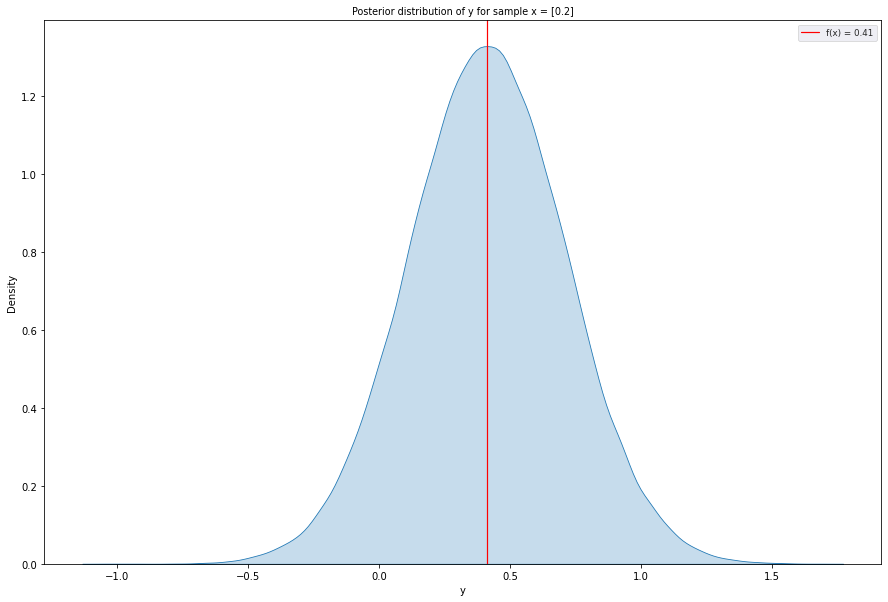

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


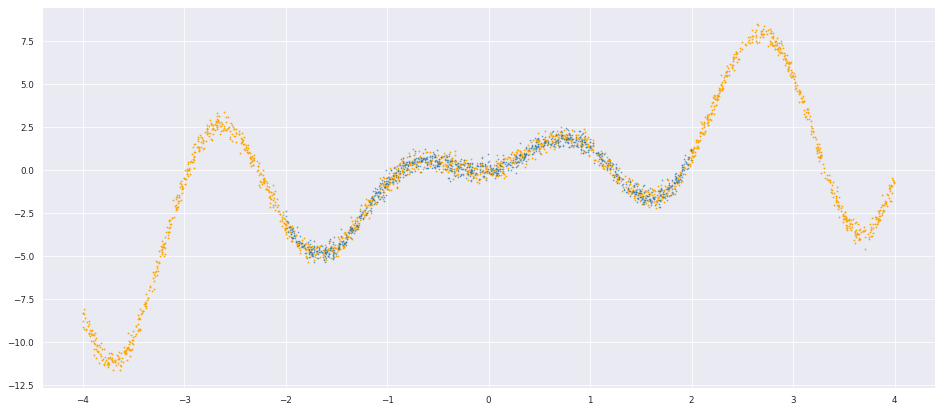

In [7]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test.squeeze(), y_test, color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1, alpha=0.5)


In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=512)

In [9]:
"""SVI"""

'SVI'

In [10]:
net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 1))
#net = nn.Linear(1, 1)
prior = tyxe.priors.IIDPrior(dist.Normal(1, 1))

obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=torch.tensor(0.1))
likelihood_guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
#likelihood_guide_builder = None

guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.bnn.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

In [11]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-4})
elbos = []
def callback(bnn, i, e):
    if i % 100 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dataloader, optim, 10000, callback=callback, num_particles=20)

epoch: 0 | elbo: 1911204.45
epoch: 100 | elbo: 1703839.2625000002
epoch: 200 | elbo: 1517719.1875
epoch: 300 | elbo: 1363385.728125
epoch: 400 | elbo: 1221663.6875
epoch: 500 | elbo: 1098930.1296875002
epoch: 600 | elbo: 996565.4046874999
epoch: 700 | elbo: 905576.975
epoch: 800 | elbo: 824272.8234375
epoch: 900 | elbo: 742692.9078124999
epoch: 1000 | elbo: 679228.5062500001
epoch: 1100 | elbo: 614532.165625
epoch: 1200 | elbo: 564188.465625
epoch: 1300 | elbo: 512521.125
epoch: 1400 | elbo: 470327.36015625
epoch: 1500 | elbo: 429243.515625
epoch: 1600 | elbo: 392409.77578125
epoch: 1700 | elbo: 359489.01328125
epoch: 1800 | elbo: 327212.12187499995
epoch: 1900 | elbo: 298094.58203125
epoch: 2000 | elbo: 272950.75546875
epoch: 2100 | elbo: 248016.03554687503
epoch: 2200 | elbo: 227103.72148437495
epoch: 2300 | elbo: 208126.819921875
epoch: 2400 | elbo: 188573.91640625
epoch: 2500 | elbo: 173033.167578125
epoch: 2600 | elbo: 158082.55859375
epoch: 2700 | elbo: 143938.3
epoch: 2800 | elb

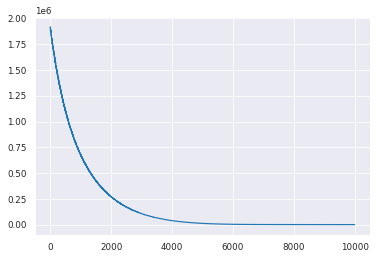

In [12]:
plt.plot(elbos)

In [13]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)
print(preds[0].shape, preds[1].shape)
print(preds[0][:4], preds[1][:4])

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

torch.Size([2000, 1]) torch.Size([2000, 1])
tensor([[-2.9428],
        [-2.9416],
        [-2.9409],
        [-2.9396]]) tensor([[1.5611],
        [1.5611],
        [1.5611],
        [1.5611]])


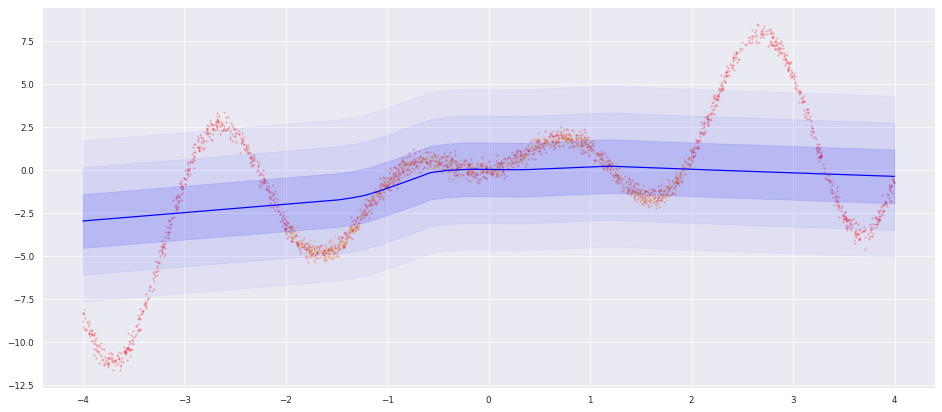

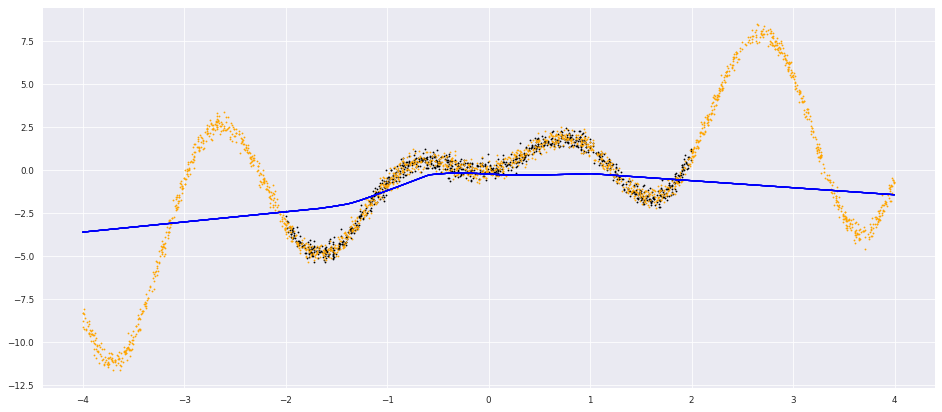

In [14]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [15]:
raise Exception("stop here")

Exception: stop here

In [ ]:
#raise Exception("stop")

In [ ]:
"""MCMC"""

'MCMC'

In [43]:
net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(1, 1))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(0.1), constraint=dist.constraints.positive))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=torch.tensor(0.1))

kernel = pyro.infer.mcmc.NUTS

bnn = tyxe.MCMC_BNN(net, prior, obs_model, kernel)

In [44]:
pyro.clear_param_store()

bnn.fit(train_dataloader, num_samples=100, warmup_steps=0)

Sample: 100%|██████████| 100/100 [00:00, 105.67it/s, step size=1.56e-02, acc. prob=0.046]


In [45]:
bnn._mcmc.diagnostics()

{'likelihood._scale': OrderedDict([('n_eff', tensor(11.3358)),
              ('r_hat', tensor(1.1046))]),
 'net.0.bias': OrderedDict([('n_eff',
               tensor([ 8.8634,  6.2860, 13.2790,  4.1252,  3.6395, 22.5226, 15.1048,  5.8652,
                       22.8684,  4.3273,  7.0010, 12.7203,  3.4703,  8.9101, 36.7653, 12.1017,
                        9.4974, 11.3098,  8.5864,  5.1440, 11.3807,  9.8417,  8.1084,  8.3322,
                       34.9564, 20.3627,  5.1505,  4.0548, 12.1286, 34.3245,  4.6074,  4.5675])),
              ('r_hat',
               tensor([1.0069, 1.3236, 1.1440, 1.4086, 1.6012, 1.0423, 1.0030, 1.2445, 1.0354,
                       1.4921, 1.1935, 1.1013, 1.5630, 1.0688, 0.9900, 1.1613, 1.0918, 1.0404,
                       1.2336, 1.3274, 1.0245, 1.1256, 1.2117, 1.1940, 0.9900, 1.0438, 1.3035,
                       1.4070, 1.1316, 1.0299, 1.4167, 1.3484]))]),
 'net.0.weight': OrderedDict([('n_eff',
               tensor([[23.0122],
                      

In [28]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

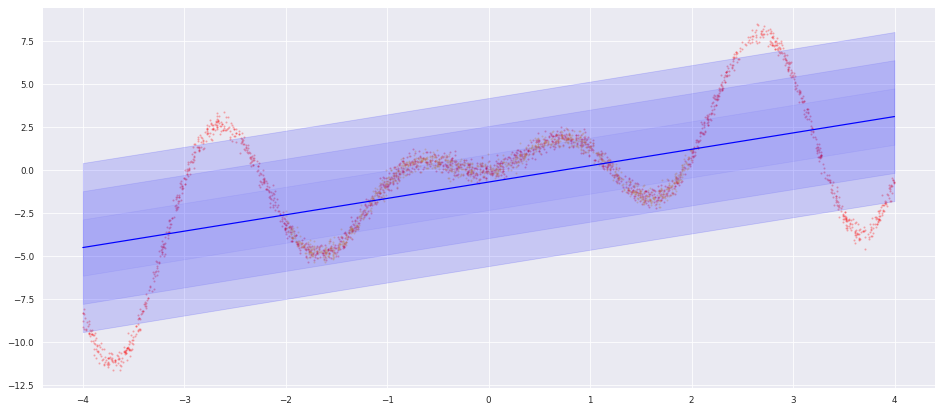

In [29]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=c/2 * 0.1, color="blue")

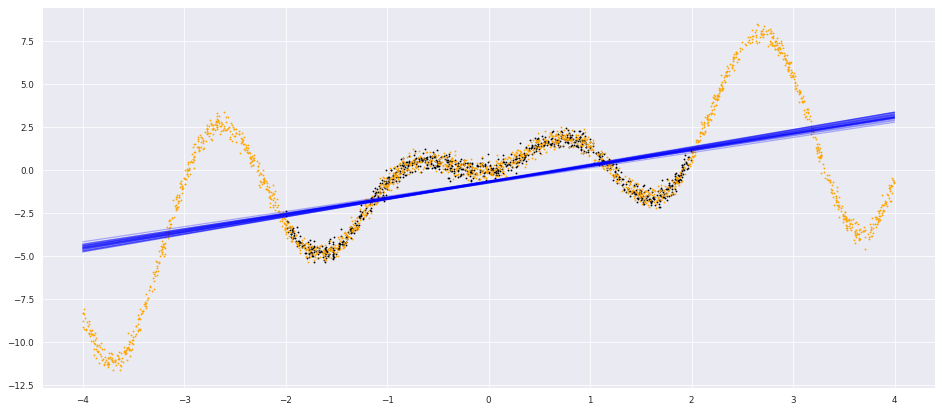

In [30]:
sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)